## Import Packages and Data

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.linear_model import Lasso, Ridge

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

In [2]:
drive.mount('/content/drive')

os.chdir("./drive/MyDrive/DSO 530 Final Project")

Mounted at /content/drive


In [3]:
option_train = pd.read_csv('option_train.csv')

In [4]:
option_train.shape

(5000, 7)

In [5]:
option_train.head(5)

,Unnamed: 0,Value,S,K,tau,r,BS
0,1,348.500,1394.46,1050,0.128767,0.0116,Under
1,2,149.375,1432.25,1400,0.679452,0.0113,Under
2,3,294.500,1478.90,1225,0.443836,0.0112,Under
3,4,3.375,1369.89,1500,0.117808,0.0119,Over
4,5,84.000,1366.42,1350,0.298630,0.0119,Under


In [6]:
# Check for missing values
option_train.isnull().sum()

Unnamed: 0    0
Value         0
S             0
K             0
tau           0
r             0
BS            0
dtype: int64

## Data Preprocessing

In [7]:
option_train['BS'] = np.where(option_train['BS'] == 'Under', 0, 1)
option_train['BS'][:5]

0    0
1    0
2    0
3    1
4    0
Name: BS, dtype: int64

In [8]:
option_train = option_train.drop(columns = ['Unnamed: 0'])

In [9]:
option_train.head(5)

,Value,S,K,tau,r,BS
0,348.500,1394.46,1050,0.128767,0.0116,0
1,149.375,1432.25,1400,0.679452,0.0113,0
2,294.500,1478.90,1225,0.443836,0.0112,0
3,3.375,1369.89,1500,0.117808,0.0119,1
4,84.000,1366.42,1350,0.298630,0.0119,0


In [10]:
# training and test set split for regression
X = option_train.drop(columns = ['Value', 'BS'])
y = option_train['Value']

re_X_train, re_X_test, re_y_train, re_y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)


In [11]:
re_X_train.shape

(4000, 4)

In [12]:
# training and test set split for classification
X = option_train.drop(columns = ['Value', 'BS'])
y = option_train['BS']

cl_X_train, cl_X_test, cl_y_train, cl_y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)

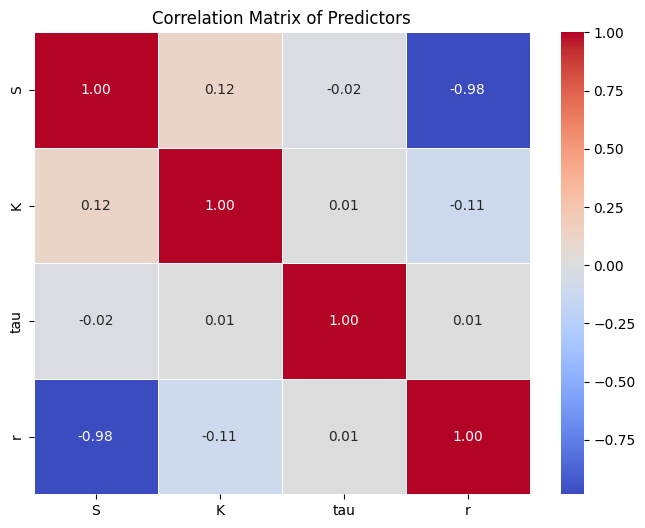

In [13]:
correlation_matrix = cl_X_train.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Predictors')
plt.show()

## Regression: 'Value' as the Response

In [14]:
# create a dataframe to track the mse of different models
prediction_model_performance = pd.DataFrame(columns = ['model_name', 'mean_squared_error'])

In [15]:
# create a dataframe to track the R_Squared of different models
prediction_model_r2 = pd.DataFrame(columns = ['model_name', 'R_squared'])

In [16]:
# Standardize the features
scaler = StandardScaler()
re_X_train_scaled = scaler.fit_transform(re_X_train)
re_X_test_scaled = scaler.transform(re_X_test)

### Linear Regression

In [17]:
# use statsmodels for modeling

lin_model = sm.OLS(re_y_train, sm.add_constant(re_X_train_scaled)).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 1.218e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:37:56   Log-Likelihood:                -19823.
No. Observations:                4000   AIC:                         3.966e+04
Df Residuals:                    3995   BIC:                         3.969e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.9928      0.544    259.359      0.0

In [18]:
r_squared = lin_model.rsquared
print("R-squared:", r_squared)

R-squared: 0.9242290886027181


In [19]:
predictions = lin_model.predict(sm.add_constant(re_X_test_scaled))

lm_mse = ((re_y_test - predictions) ** 2).mean()
print("Mean Squared Error:", lm_mse)

Mean Squared Error: 1153.7489899704083


In [20]:
new = {'model_name': 'Linear Regression', 'mean_squared_error': lm_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.74899


In [21]:
newr = {'model_name': 'Linear Regression', 'R_squared': r_squared}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229


### Best Subset Selection

In [22]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

In [23]:
# Define a function to fit a model based on a subset of features
def fit_subset_model(features, X_train, y_train):
    model = LinearRegression()
    model.fit(X_train[:, features], y_train)
    return model

# Iterate over all possible combinations of features
def best_subset_selection(X_train, y_train, feature_names, max_features):
    best_score = -np.inf
    best_subset = None
    all_features = range(len(feature_names))

    for k in range(1, max_features + 1):
        for subset in combinations(all_features, k):
            subset = list(subset)
            model = fit_subset_model(subset, X_train, y_train)
            scores = cross_val_score(model, X_train[:, subset], y_train, cv=5)
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_subset = subset

    return best_subset

# Apply best subset selection
# scaler = StandardScaler()
# re_X_train_scaled = scaler.fit_transform(re_X_train)
# re_X_test_scaled = scaler.transform(re_X_test)

max_features = re_X_train_scaled.shape[1]
best_subset_indices = best_subset_selection(re_X_train_scaled, re_y_train, X.columns, max_features)
best_features = [X.columns[i] for i in best_subset_indices]

# Train final model using best features
final_model = fit_subset_model(best_subset_indices, re_X_train_scaled, re_y_train)

# Evaluate on test set
test_score_r2 = final_model.score(re_X_test_scaled[:, best_subset_indices], re_y_test)
print("Test R^2 score:", test_score_r2)

Test R^2 score: 0.9277485886438211


In [24]:
coefs = final_model.coef_
intercept = final_model.intercept_

predictions = final_model.predict(re_X_test_scaled[:, best_subset_indices])
bss_mse = mean_squared_error(re_y_test, predictions)

In [25]:
print("Features in the best model:")
for feature, coef in zip(best_features, coefs):
    print(f"{feature}: {coef}")

# Print intercept
print(f"Intercept: {intercept}")

# Print MSE
print(f"Mean Squared Error (MSE): {bss_mse}")

Features in the best model:
S: 33.809575218955544
K: -115.27605443477695
tau: 35.72631233971331
Intercept: 140.99279687499987
Mean Squared Error (MSE): 1153.770471152697


In [26]:
new = {'model_name': 'Best Subset Selection', 'mean_squared_error': bss_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471


In [27]:
newr = {'model_name': 'Best Subset Selection', 'R_squared': test_score_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749


### K-Nearest Neighbors (KNN) for regression

In [28]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(re_X_train_scaled, re_y_train)

# Predict on the testing set
predictions = knn_regressor.predict(re_X_test_scaled)

# Calculate evaluation metrics
knn_mse = mean_squared_error(re_y_test, predictions)
print("Mean Squared Error:", knn_mse)

knn_r2 = r2_score(re_y_test, predictions)
print("R-squared (KNN Regression):", knn_r2)

Mean Squared Error: 217.66854125
R-squared (KNN Regression): 0.986369161192485


In [29]:
new = {'model_name': 'KNN Regression', 'mean_squared_error': knn_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541


In [30]:
newr = {'model_name': 'KNN Regression', 'R_squared': knn_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369


### Decision Trees for Regression

In [31]:
decision_tree_regressor = DecisionTreeRegressor(random_state=42)

# Fit the Decision Tree regressor to the training data
decision_tree_regressor.fit(re_X_train, re_y_train)

# Predict on the testing set
predictions = decision_tree_regressor.predict(re_X_test)

# Calculate evaluation metrics
dt_mse = mean_squared_error(re_y_test, predictions)

print("Decision Tree Regression:")
print("Mean Squared Error:", dt_mse)

dt_r2 = r2_score(re_y_test, predictions)
print("R-squared (Decision Tree):", dt_r2)

Decision Tree Regression:
Mean Squared Error: 118.4627919921875
R-squared (Decision Tree): 0.9925816233569595


In [32]:
new = {'model_name': 'Decision Tree Regression', 'mean_squared_error': dt_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792


In [33]:
newr = {'model_name': 'Decision Trees for Regression', 'R_squared': dt_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582


### Random Forest Regression

No need to scale data before fit the model (we tried with the scaled data, but the model performance is almost similar as that of model using original data). Because random forest does not rely on distance-based calculation or gradient descent, the scale of features does not affect its performance.

In [34]:
random_forest_regressor = RandomForestRegressor(n_estimators=50, random_state=42)

# Fit the Random Forest regressor to the training data
random_forest_regressor.fit(re_X_train, re_y_train)

# Predict on the testing set
predictions = random_forest_regressor.predict(re_X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(re_y_test, predictions)
print("Mean Squared Error:", rf_mse)

rf_r2 = r2_score(re_y_test, predictions)
print("R-squared (Random Forest):", rf_r2)

Mean Squared Error: 55.937986762109375
R-squared (Random Forest): 0.9964970515427147


In [35]:
new = {'model_name': 'Random Forest Regression', 'mean_squared_error': rf_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792
4,Random Forest Regression,55.937987


In [36]:
newr = {'model_name': 'Random Forest Regression', 'R_squared': rf_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582
4,Random Forest Regression,0.996497


### Lasso Regression

In [37]:
lasso_regressor = Lasso(alpha=0.1)

# Fit the Lasso regressor to the training data
lasso_regressor.fit(re_X_train_scaled, re_y_train)

# Predict on the testing set
lasso_predictions = lasso_regressor.predict(re_X_test_scaled)

# Calculate evaluation metrics for Lasso Regression
lasso_mse = mean_squared_error(re_y_test, lasso_predictions)
print("Mean Squared Error:", lasso_mse)

lasso_r2 = r2_score(re_y_test, lasso_predictions)
print("R-squared (Lasso Regression):", lasso_r2)

Mean Squared Error: 1154.1152538584588
R-squared (Lasso Regression): 0.9277269976621438


In [38]:
new = {'model_name': 'Lasso Regression', 'mean_squared_error': lasso_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792
4,Random Forest Regression,55.937987
5,Lasso Regression,1154.115254


In [39]:
newr = {'model_name': 'Lasso Regression', 'R_squared': lasso_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582
4,Random Forest Regression,0.996497
5,Lasso Regression,0.927727


### Ridge Regression

In [40]:
ridge_regressor = Ridge(alpha=1)

# Fit the Ridge regressor to the training data
ridge_regressor.fit(re_X_train_scaled, re_y_train)

# Predict on the testing set
ridge_predictions = ridge_regressor.predict(re_X_test_scaled)

# Calculate evaluation metrics for Ridge Regression
ridge_mse = mean_squared_error(re_y_test, ridge_predictions)
print("Mean Squared Error:", ridge_mse)

ridge_r2 = r2_score(re_y_test, ridge_predictions)
print("R-squared (Ridge Regression):", ridge_r2)

Mean Squared Error: 1153.8426548577925
R-squared (Ridge Regression): 0.9277440683560338


In [41]:
new = {'model_name': 'Ridge Regression', 'mean_squared_error': ridge_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792
4,Random Forest Regression,55.937987
5,Lasso Regression,1154.115254
6,Ridge Regression,1153.842655


In [42]:
newr = {'model_name': 'Ridge Regression', 'R_squared': ridge_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582
4,Random Forest Regression,0.996497
5,Lasso Regression,0.927727
6,Ridge Regression,0.927744


### Support Vector Machine for Regression

In [43]:
svm_regressor = SVR(kernel='linear')

# Fit the SVR model to the training data
svm_regressor.fit(re_X_train_scaled, re_y_train)

# Predict on the testing set
svm_predictions = svm_regressor.predict(re_X_test_scaled)

# Calculate evaluation metrics
svm_mse = mean_squared_error(re_y_test, svm_predictions)

print("Support Vector Machine (SVR):")
print("Mean Squared Error:", svm_mse)

svr_r2 = r2_score(re_y_test, svm_predictions)
print("R-squared (SVR):", svr_r2)

Support Vector Machine (SVR):
Mean Squared Error: 1321.90098183137
R-squared (SVR): 0.9172199202541432


In [44]:
new = {'model_name': 'SVM for Regression', 'mean_squared_error': svm_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792
4,Random Forest Regression,55.937987
5,Lasso Regression,1154.115254
6,Ridge Regression,1153.842655
7,SVM for Regression,1321.900982


In [45]:
newr = {'model_name': 'SVM for Regression', 'R_squared': svr_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582
4,Random Forest Regression,0.996497
5,Lasso Regression,0.927727
6,Ridge Regression,0.927744
7,SVM for Regression,0.917220


### 2 Hidden Layers Neural Networks

In [46]:
def create_model():
  # Define the neural network architecture
  model = Sequential()
  # Input layer with 64 neurons and ReLU activation
  model.add(Dense(64, input_dim= re_X_train.shape[1], activation='relu'))
  # Hidden layer with 32 neurons and ReLU activation
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='linear'))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])
  return model

model1 = create_model()
model1.summary()


checkpoint_dir = "checkpoints"
import os
try:
    os.mkdir(checkpoint_dir)
except:
    pass

filename1 = "weights-best-prediction-model.hdf5"   # this path saves the best model I want
filepath1 = os.path.join(checkpoint_dir, filename1)
checkpointer = keras.callbacks.ModelCheckpoint(filepath1,  # save best model parameters
                                               monitor='val_mse',  # we use the validation mse to measure the performance
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='auto')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2433 (9.50 KB)
Trainable params: 2433 (9.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
X = option_train.drop(columns = ['Value', 'BS'])
y = option_train['Value']

In [48]:
# Define number of folds for cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize list to store validation MSEs
validation_mses = []
out_of_sample_r2 = []

y = np.array(y)

# Perform K-fold cross-validation
for train_index, val_index in kfold.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize and fit the scaler on training data
    scaler = StandardScaler()  # or MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Transform validation data using the same scaler
    X_val_scaled = scaler.transform(X_val)

    # Create and compile the model
    model1 = create_model()

    # Train the model
    history1 = model1.fit(X_train_scaled, y_train,
               epochs=50, batch_size=32,
               verbose=1,
               validation_split = 0.2,
               callbacks = [checkpointer])

    # Evaluate the model on validation data
    mse = model1.evaluate(X_val_scaled, y_val, verbose=0)[1]  # Get MSE from evaluation result
    validation_mses.append(mse)

    # Evaluate the model on R^2
    prediction = model1.predict(X_val_scaled)
    nn_r2 = r2_score(y_val, prediction)
    out_of_sample_r2.append(nn_r2)

# Calculate and print average validation accuracy
print("Average Validation MSE:", np.mean(validation_mses))

# Calculate and print average out-of-sample R^2
print("Average Out-of-sample R^2:", np.mean(nn_r2))

Epoch 1/50
 85/100 [========================>.....] - ETA: 0s - loss: 33796.6250 - mse: 33796.6250
Epoch 1: val_mse improved from inf to 34524.08203, saving model to checkpoints/weights-best-prediction-model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 2s 10ms/step - loss: 33998.8711 - mse: 33998.8711 - val_loss: 34524.0820 - val_mse: 34524.0820
Epoch 2/50
 90/100 [==========================>...] - ETA: 0s - loss: 28852.7832 - mse: 28852.7832
Epoch 2: val_mse improved from 34524.08203 to 22176.93945, saving model to checkpoints/weights-best-prediction-model.hdf5
100/100 [==============================] - 0s 4ms/step - loss: 27867.4824 - mse: 27867.4824 - val_loss: 22176.9395 - val_mse: 22176.9395
Epoch 3/50
 87/100 [=========================>....] - ETA: 0s - loss: 13187.7100 - mse: 13187.7100
Epoch 3: val_mse improved from 22176.93945 to 5584.99756, saving model to checkpoints/weights-best-prediction-model.hdf5
100/100 [==============================] - 0s 4ms/step - loss: 12255.1797 - mse: 12255.1797 - val_loss: 5584.9976 - val_mse: 5584.9976
Epoch 4/50
 94/100 [===========================>..] - ETA: 0s - loss: 2812.6011 - mse: 2812.6011
Epoch 4: val_mse improved from 5584.99756 to 1234.05

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 1s 7ms/step - loss: 34.7437 - mse: 34.7437 - val_loss: 37.3193 - val_mse: 37.3193
Epoch 48/50
 75/100 [=====================>........] - ETA: 0s - loss: 34.3670 - mse: 34.3670
Epoch 48: val_mse improved from 37.31926 to 36.67036, saving model to checkpoints/weights-best-prediction-model.hdf5
100/100 [==============================] - 0s 3ms/step - loss: 34.5336 - mse: 34.5336 - val_loss: 36.6704 - val_mse: 36.6704
Epoch 49/50
 98/100 [============================>.] - ETA: 0s - loss: 34.2383 - mse: 34.2383
Epoch 49: val_mse did not improve from 36.67036
100/100 [==============================] - 0s 2ms/step - loss: 34.1716 - mse: 34.1716 - val_loss: 37.1508 - val_mse: 37.1508
Epoch 50/50
 66/100 [==================>...........] - ETA: 0s - loss: 33.6162 - mse: 33.6162
Epoch 50: val_mse improved from 36.67036 to 36.36855, saving model to checkpoints/weights-best-prediction-model.hdf5
32/32 [==============================] - 0s 1ms/step
Epoch 1/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 1s 5ms/step - loss: 33.2025 - mse: 33.2025 - val_loss: 36.2638 - val_mse: 36.2638
Epoch 49/50
 66/100 [==================>...........] - ETA: 0s - loss: 32.4033 - mse: 32.4033
Epoch 49: val_mse improved from 36.26382 to 35.92748, saving model to checkpoints/weights-best-prediction-model.hdf5
100/100 [==============================] - 0s 2ms/step - loss: 33.0729 - mse: 33.0729 - val_loss: 35.9275 - val_mse: 35.9275
Epoch 50/50
 98/100 [============================>.] - ETA: 0s - loss: 32.7605 - mse: 32.7605
Epoch 50: val_mse improved from 35.92748 to 35.38141, saving model to checkpoints/weights-best-prediction-model.hdf5
32/32 [==============================] - 0s 2ms/step
Epoch 1/50
 98/100 [============================>.] - ETA: 0s - loss: 33550.8867 - mse: 33550.8867
Epoch 1: val_mse did not improve from 35.38141
100/100 [==============================] - 1s 5ms/step - loss: 33530.6367 - mse: 33530.6367 - val_loss: 34308.0742 - val_mse: 343

<ipython-input-49-159640f141b1>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_mse, "b", label="Validation error (MSE)", color = 'Red')


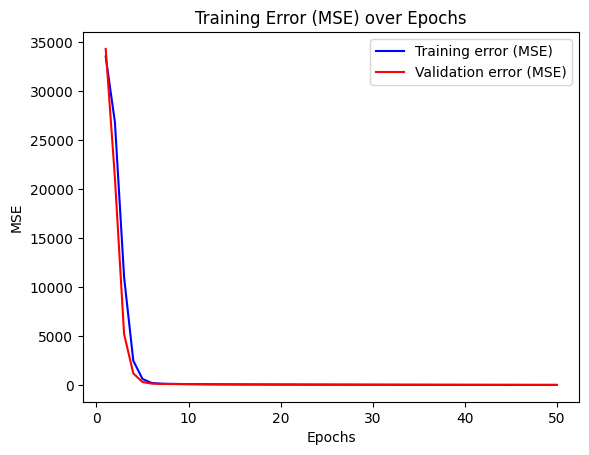

In [49]:
import matplotlib.pyplot as plt

train_mse = history1.history['mse']
val_mse = history1.history['val_mse']
epochs = range(1, len(train_mse) + 1)

plt.plot(epochs, train_mse, 'b', label = 'Training error (MSE)')
plt.plot(epochs, val_mse, "b", label="Validation error (MSE)", color = 'Red')
plt.title('Training Error (MSE) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [52]:
new = {'model_name': 'Neural Networks for Regression', 'mean_squared_error': np.mean(validation_mses)}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792
4,Random Forest Regression,55.937987
5,Lasso Regression,1154.115254
6,Ridge Regression,1153.842655
7,SVM for Regression,1321.900982
8,Neural Networks for Regression,34.766048


In [53]:
newr = {'model_name': 'Neural Networks for Regression', 'R_squared': np.mean(out_of_sample_r2)}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582
4,Random Forest Regression,0.996497
5,Lasso Regression,0.927727
6,Ridge Regression,0.927744
7,SVM for Regression,0.917220
8,Neural Networks for Regression,0.997777


### Radial Basis Function Networks

In [54]:
# SVM by using kernal = rbf

gamma = 0.1
svr_rbf = SVR(kernel='rbf', gamma=gamma)
svr_rbf.fit(re_X_train_scaled, re_y_train)

# Making predictions on the test set
re_y_pred = svr_rbf.predict(re_X_test_scaled)

# Evaluating the model
rbf_mse = mean_squared_error(re_y_test, re_y_pred)
print("Mean Squared Error:", rbf_mse)

rbf_r2 = r2_score(re_y_test, re_y_pred)
print("R-squared (Radial Basis Function Networks):", rbf_r2)

Mean Squared Error: 1242.5628213794087
R-squared (Radial Basis Function Networks): 0.9221882343255982


In [55]:
new = {'model_name': 'Radial Basis Function Networks', 'mean_squared_error': rbf_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792
4,Random Forest Regression,55.937987
5,Lasso Regression,1154.115254
6,Ridge Regression,1153.842655
7,SVM for Regression,1321.900982
8,Neural Networks for Regression,34.766048
9,Radial Basis Function Networks,1242.562821


In [56]:
newr = {'model_name': 'Radial Basis Function Networks', 'R_squared': rbf_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582
4,Random Forest Regression,0.996497
5,Lasso Regression,0.927727
6,Ridge Regression,0.927744
7,SVM for Regression,0.917220
8,Neural Networks for Regression,0.997777
9,Radial Basis Function Networks,0.922188


### Gradient Boosting Regressor

In [57]:
# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the regressor on the training data
gb_regressor.fit(re_X_train_scaled, re_y_train)

re_y_pred = gb_regressor.predict(re_X_test_scaled)

gb_mse = mean_squared_error(re_y_test, re_y_pred)
print("Mean Squared Error:", gb_mse)

gb_r2 = r2_score(re_y_test, re_y_pred)
print("R-squared (Gradient Boosting Regressor):", gb_r2)

Mean Squared Error: 71.22359358360602
R-squared (Gradient Boosting Regressor): 0.9955398363132546


In [58]:
new = {'model_name': 'Gradient Boosting Regressor', 'mean_squared_error': gb_mse}
prediction_model_performance.loc[len(prediction_model_performance)] = new
prediction_model_performance

,model_name,mean_squared_error
0,Linear Regression,1153.748990
1,Best Subset Selection,1153.770471
2,KNN Regression,217.668541
3,Decision Tree Regression,118.462792
4,Random Forest Regression,55.937987
5,Lasso Regression,1154.115254
6,Ridge Regression,1153.842655
7,SVM for Regression,1321.900982
8,Neural Networks for Regression,34.766048
9,Radial Basis Function Networks,1242.562821


In [59]:
newr = {'model_name': 'Gradient Boosting Regressor', 'R_squared': gb_r2}
prediction_model_r2.loc[len(prediction_model_r2)] = newr
prediction_model_r2

,model_name,R_squared
0,Linear Regression,0.924229
1,Best Subset Selection,0.927749
2,KNN Regression,0.986369
3,Decision Trees for Regression,0.992582
4,Random Forest Regression,0.996497
5,Lasso Regression,0.927727
6,Ridge Regression,0.927744
7,SVM for Regression,0.917220
8,Neural Networks for Regression,0.997777
9,Radial Basis Function Networks,0.922188


## Classification: 'BS' as the Response

In [60]:
# create a df to track the performance of different models
classification_model_performance = pd.DataFrame(columns = ['model_name', 'classification_error'])

In [61]:
# Standardize the features
scaler = StandardScaler()
cl_X_train_scaled = scaler.fit_transform(cl_X_train)
cl_X_test_scaled = scaler.transform(cl_X_test)

### Logistic Regression

In [62]:
model = LogisticRegression()

model.fit(cl_X_train_scaled, cl_y_train)

y_pred = model.predict(cl_X_test_scaled)
accuracy = accuracy_score(cl_y_test, y_pred)
logit_classification_error = 1 - accuracy
print(f"logit classification error:\n{logit_classification_error}\n")

logit classification error:
0.10599999999999998



In [63]:
new = {'model_name': 'Logistic Regression', 'classification_error': logit_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.106


### Best Subset Selection on Logistic Regression

In [64]:
# Define a function to fit a model based on a subset of features
def fit_subset_model(features, X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train[:, features], y_train)
    return model

# Iterate over all possible combinations of features
def best_subset_selection(X_train, y_train, max_features):
    best_score = -np.inf
    best_subset = None
    all_features = range(X_train.shape[1])

    for k in range(1, max_features + 1):
        for subset in combinations(all_features, k):
            subset = list(subset)
            model = fit_subset_model(subset, X_train, y_train)
            scores = cross_val_score(model, X_train[:, subset], y_train, cv=5, scoring='accuracy')
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_subset = subset

    return best_subset

In [65]:
max_features = cl_X_train_scaled.shape[1]
best_features = best_subset_selection(cl_X_train_scaled, cl_y_train, max_features)

# Train final model using best features
final_model = fit_subset_model(best_features, cl_X_train_scaled, cl_y_train)

best_feature_names = [X.columns[i] for i in best_features]

print("Features in the best model:")
for feature_name in best_feature_names:
    print(feature_name)

# Evaluate on test set
test_accuracy = final_model.score(cl_X_test_scaled[:, best_features], cl_y_test)
print("Test Accuracy:", test_accuracy)
bss_classification_error = 1 - test_accuracy
print("Classification error:", bss_classification_error)

Features in the best model:
S
K
tau
r
Test Accuracy: 0.894
Classification error: 0.10599999999999998


In [66]:
new = {'model_name': 'Logistic Regression after Best Subset Selection', 'classification_error': bss_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.106
1,Logistic Regression after Best Subset Selection,0.106


### Quadratic Discriminant Analysis (QDA)

In [67]:
qda_model = QuadraticDiscriminantAnalysis()

# Fit the QDA model on scaled data
qda_model.fit(cl_X_train_scaled, cl_y_train)

# Evaluate on test set
test_accuracy = qda_model.score(cl_X_test_scaled, cl_y_test)
print("Test Accuracy (QDA with scaled data):", test_accuracy)
qda_classification_error = 1 - test_accuracy
print("Classification error:", qda_classification_error)

Test Accuracy (QDA with scaled data): 0.892
Classification error: 0.10799999999999998


In [68]:
new = {'model_name': 'Quadratic Discriminant Analysis', 'classification_error': qda_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.106
1,Logistic Regression after Best Subset Selection,0.106
2,Quadratic Discriminant Analysis,0.108


### K-Nearest Neighbours

In [69]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(cl_X_train_scaled, cl_y_train)

y_pred = knn_classifier.predict(cl_X_test_scaled)
accuracy = accuracy_score(cl_y_test, y_pred)
knn_classification_error = 1 - accuracy
print(f"Classification error:\n{knn_classification_error}\n")

Classification error:
0.08999999999999997



In [70]:
new = {'model_name': 'KNN Classification', 'classification_error': knn_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.106
1,Logistic Regression after Best Subset Selection,0.106
2,Quadratic Discriminant Analysis,0.108
3,KNN Classification,0.090


### Decision Trees

In [71]:
model = DecisionTreeClassifier(random_state=42)

model.fit(cl_X_train, cl_y_train)

y_pred = model.predict(cl_X_test)
accuracy = accuracy_score(cl_y_test, y_pred)
dt_classification_error = 1 - accuracy
print(f"Classification error:\n{dt_classification_error}\n")

Classification error:
0.07999999999999996



In [72]:
new = {'model_name': 'Decision Trees', 'classification_error': dt_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.106
1,Logistic Regression after Best Subset Selection,0.106
2,Quadratic Discriminant Analysis,0.108
3,KNN Classification,0.090
4,Decision Trees,0.080


### Random Forests

In [73]:
param = {'n_estimators': [10, 25, 50, 75, 100, 150, 200]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                             param,
                             cv = 5,
                             scoring = 'accuracy')

grid_search.fit(cl_X_train, cl_y_train)

best_n_estimator = grid_search.best_params_['n_estimators']
print(f'Best number of trees in the forest: {best_n_estimator}')


Best number of trees in the forest: 200


In [81]:
max_features = {'max_features': [1, 2, 3, 4]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                             max_features,
                             cv = 5,
                             scoring = 'accuracy')

grid_search.fit(cl_X_train, cl_y_train)

best_max_features = grid_search.best_params_['max_features']
print(f'Best max depth in the forest: {best_max_features}')

Best max depth in the forest: 1


In [128]:
model = RandomForestClassifier(n_estimators = 200, random_state=42,
                               max_features = 1)

In [108]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, cl_X_train, cl_y_train, cv=5)
mean_accuracy = scores.mean()
rf_classification_error = 1 - mean_accuracy
print(f"Classification error:\n{rf_classification_error}\n")

Classification error:
0.06624999999999992



In [113]:
new = {'model_name': 'Random Forest', 'classification_error': rf_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.10600
1,Logistic Regression after Best Subset Selection,0.10600
2,Quadratic Discriminant Analysis,0.10800
3,KNN Classification,0.09000
4,Decision Trees,0.08000
5,Random Forest,0.06625


In [109]:
feature_names = np.array(cl_X_train.columns)

Text(0.5, 0, 'Random Forest Feature Importance')

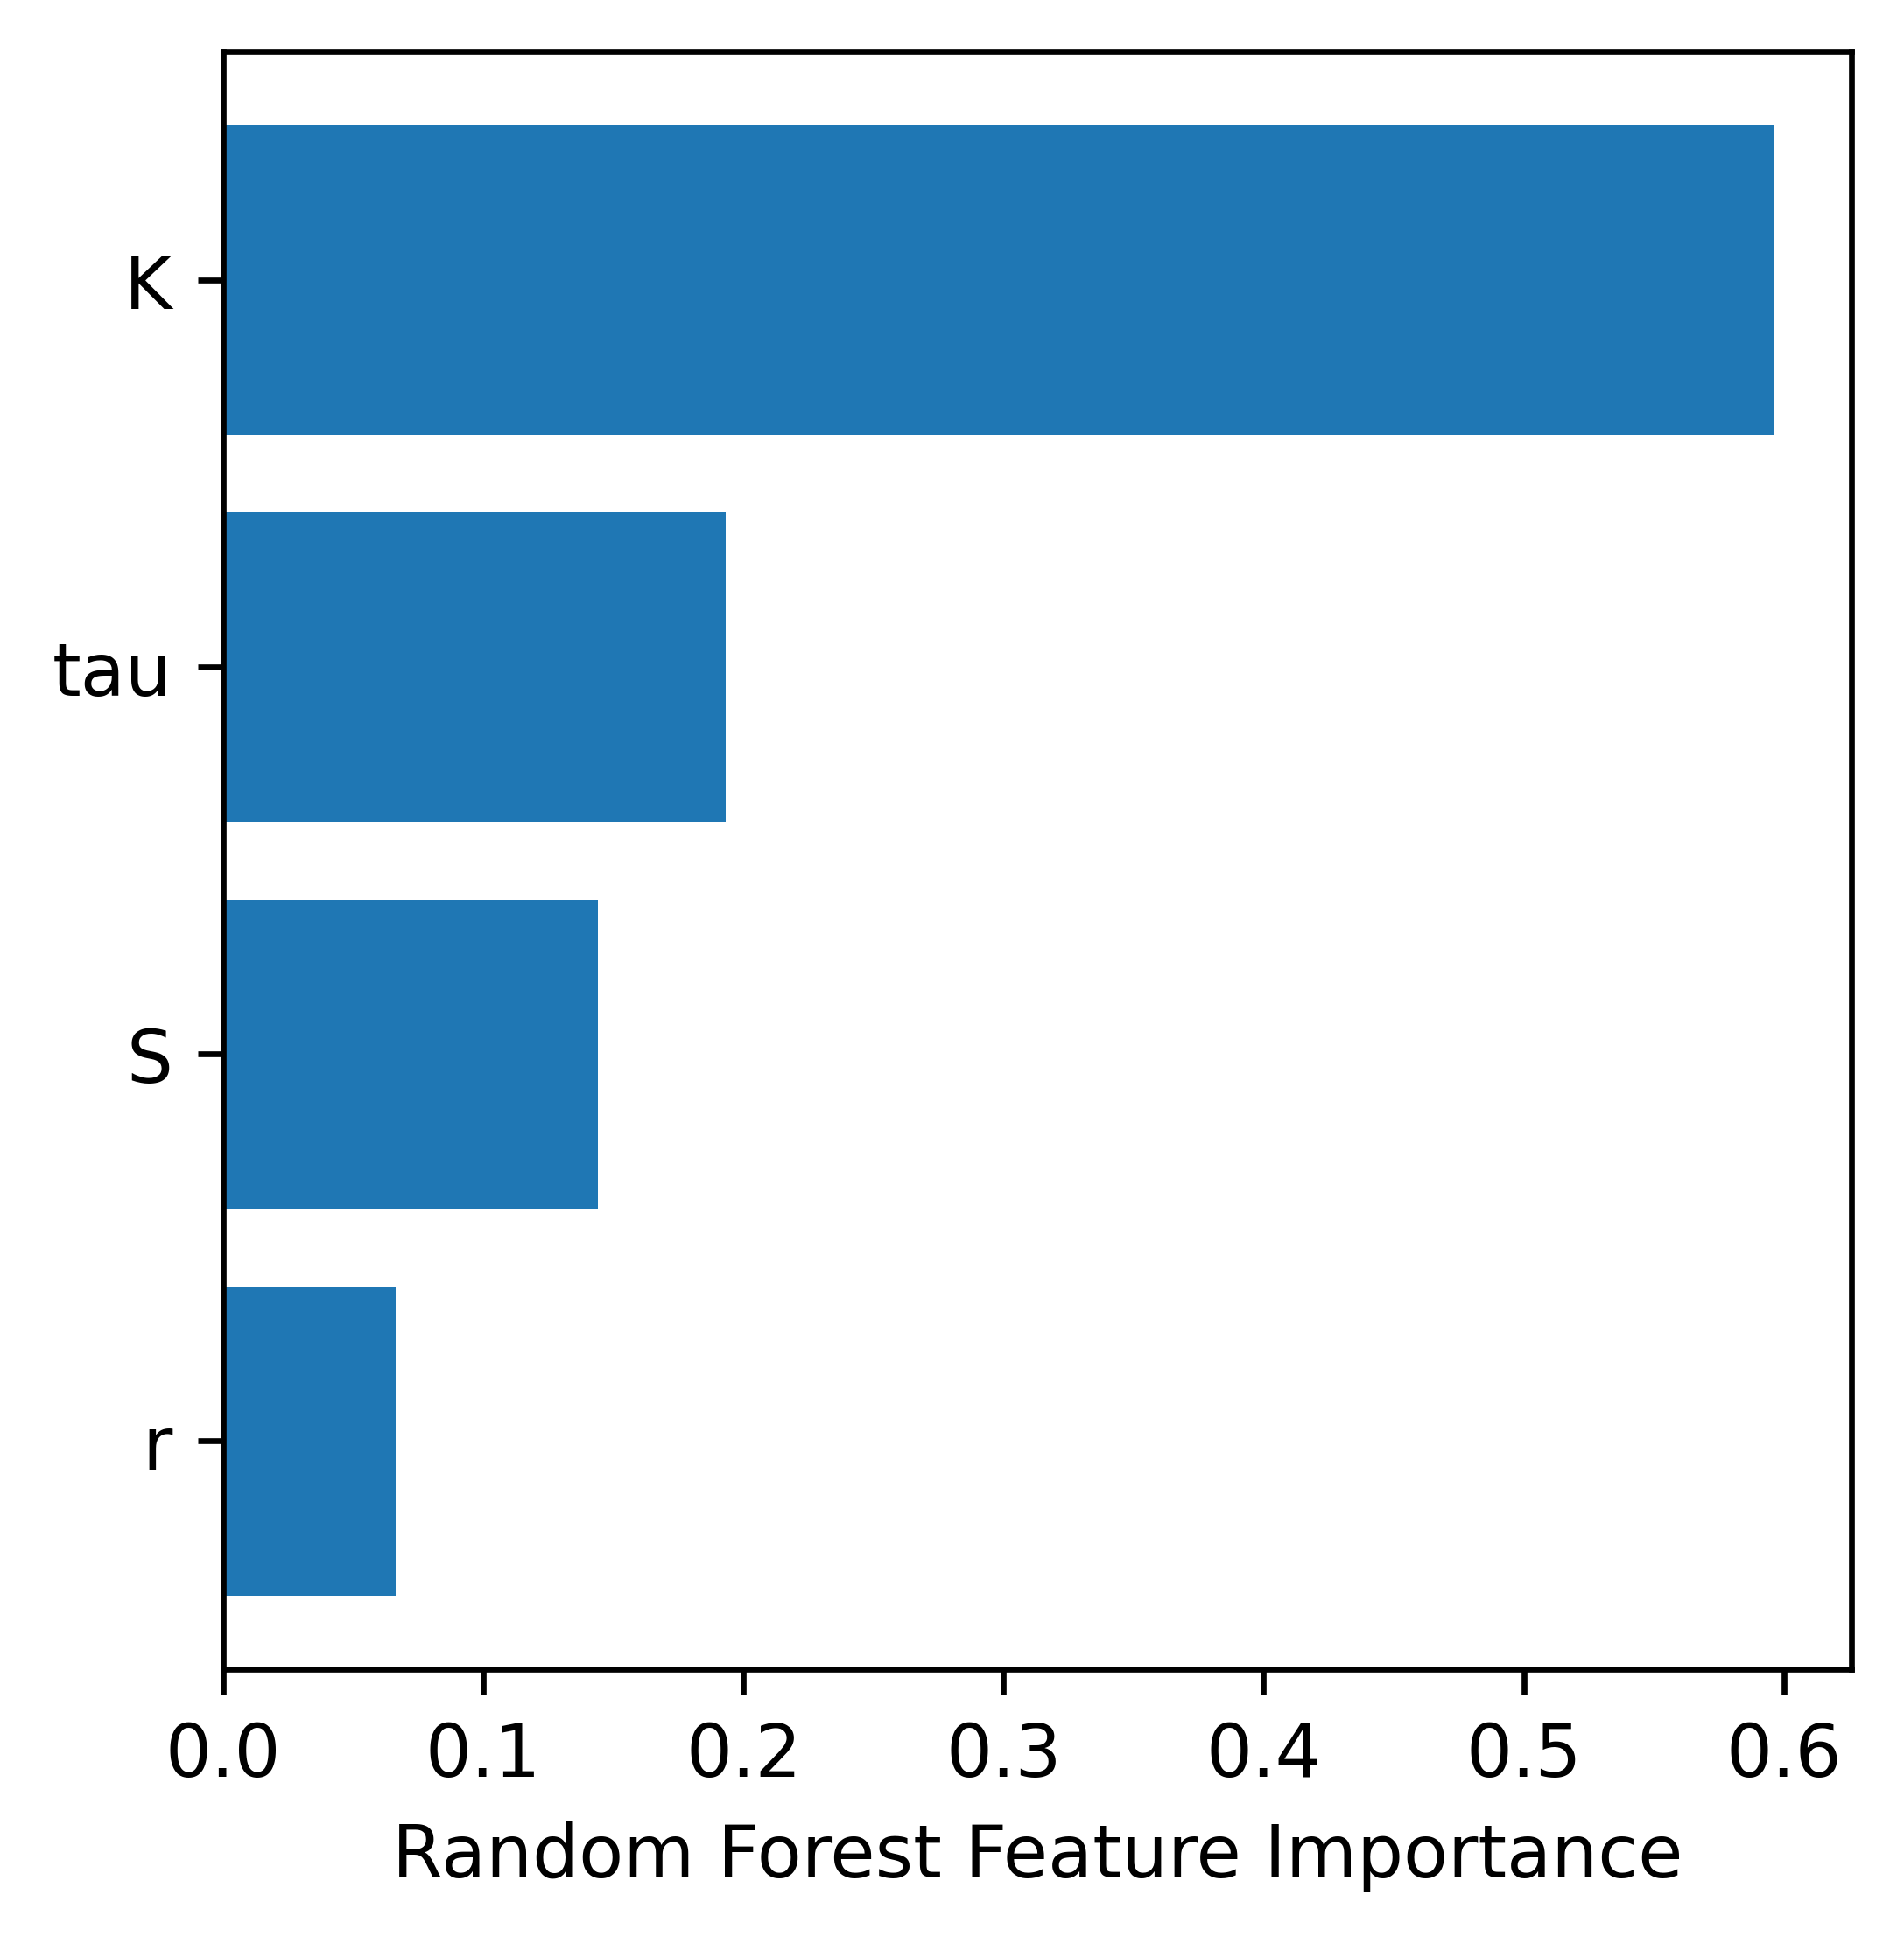

In [111]:
## plot the top 10 features in terms of Gini index
model.fit(cl_X_train, cl_y_train)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
sorted_idx = model.feature_importances_.argsort()[-10:] ## remove [-10:] to get a plot for all features

plt.barh(feature_names[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

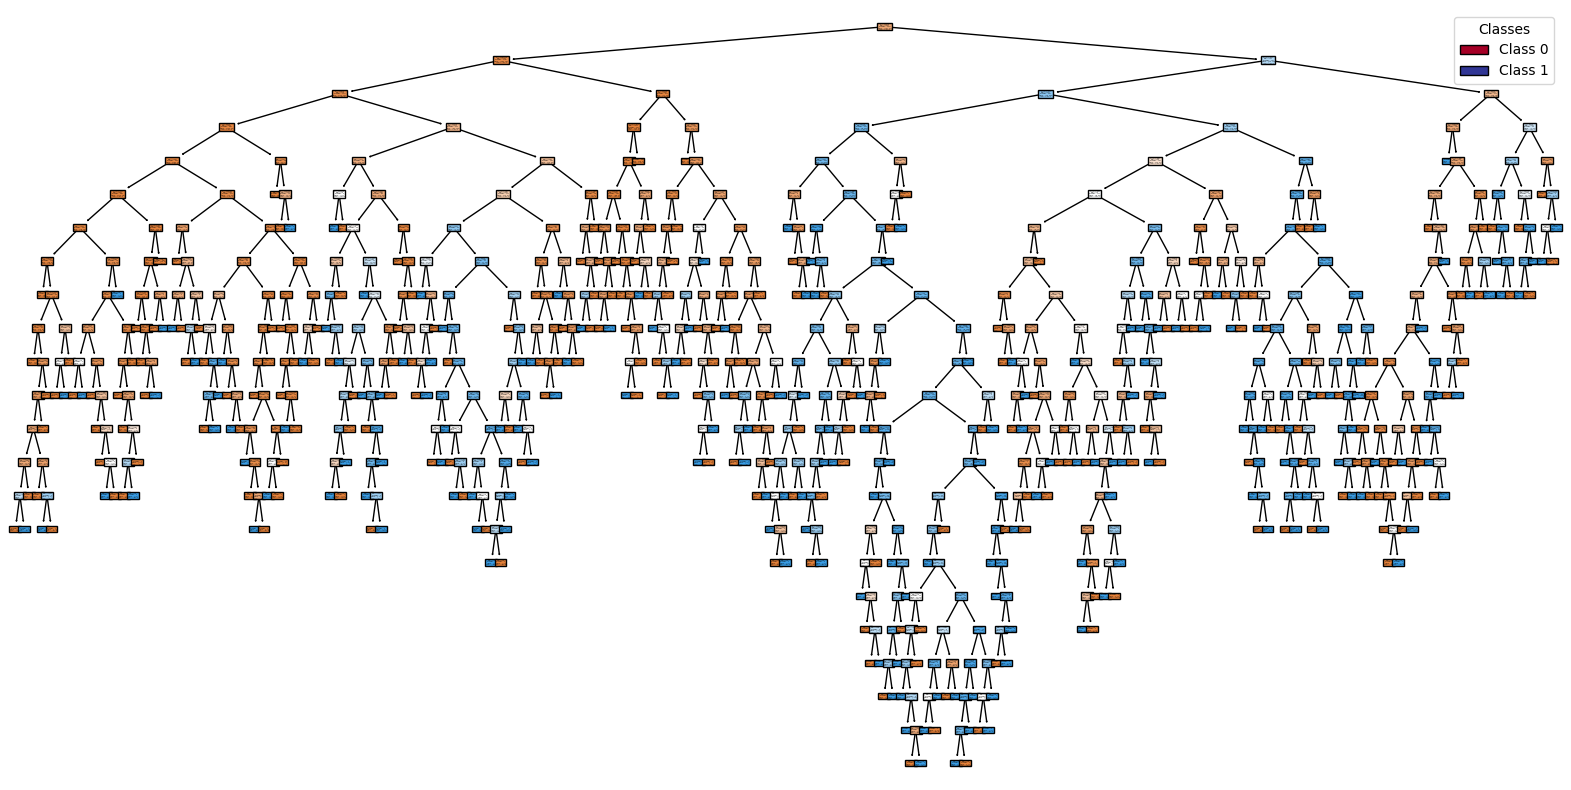

In [112]:
from sklearn.tree import plot_tree

# Select a tree from the trained Random Forest model
tree_to_visualize = model.estimators_[0]  # Visualizing the first tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(tree_to_visualize, filled=True, feature_names=cl_X_train.columns.tolist(),
          class_names=['Class 0', 'Class 1'], ax=ax)

from matplotlib.patches import Patch
legend_labels = [Patch(facecolor=plt.cm.RdYlBu(i / 1), edgecolor='k', label=f'Class {i}') for i in range(2)]
ax.legend(handles=legend_labels, title="Classes", loc='best')

plt.show()

### Support Vector Machines (SVM)

In [114]:
model = SVC()   # it choose kernal = 'rbf' automatically

model.fit(cl_X_train_scaled, cl_y_train)

y_pred = model.predict(cl_X_test_scaled)
accuracy = accuracy_score(cl_y_test, y_pred)
svm_classification_error = 1 - accuracy
print(f"Classification error:\n{svm_classification_error}\n")

Classification error:
0.09899999999999998



In [115]:
new = {'model_name': 'SVM', 'classification_error': svm_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.10600
1,Logistic Regression after Best Subset Selection,0.10600
2,Quadratic Discriminant Analysis,0.10800
3,KNN Classification,0.09000
4,Decision Trees,0.08000
5,Random Forest,0.06625
6,SVM,0.09900


### 3 Hidden Layers Neural Networks

In [116]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(cl_X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

checkpoint_dir = "checkpoints"
import os
try:
    os.mkdir(checkpoint_dir)
except:
    pass

filename = "weights-best-classification-model.hdf5"   # this path saves the best model I want
filepath = os.path.join(checkpoint_dir, filename)
checkpointer = keras.callbacks.ModelCheckpoint(filepath,  # save best model parameters
                                               monitor='val_accuracy',  # we use the validation accuracy to measure the performance
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='auto')


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                320       
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [117]:
history2 = model2.fit(cl_X_train_scaled, cl_y_train,
                    epochs=50, batch_size=32,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks = [checkpointer])

Epoch 1/50
 85/100 [========================>.....] - ETA: 0s - loss: 0.4098 - accuracy: 0.8088
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to checkpoints/weights-best-classification-model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 2s 10ms/step - loss: 0.3925 - accuracy: 0.8191 - val_loss: 0.2491 - val_accuracy: 0.9000
Epoch 2/50
 93/100 [==========================>...] - ETA: 0s - loss: 0.2668 - accuracy: 0.8874
Epoch 2: val_accuracy improved from 0.90000 to 0.90250, saving model to checkpoints/weights-best-classification-model.hdf5
100/100 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.8894 - val_loss: 0.2221 - val_accuracy: 0.9025
Epoch 3/50
 87/100 [=========================>....] - ETA: 0s - loss: 0.2457 - accuracy: 0.8966
Epoch 3: val_accuracy improved from 0.90250 to 0.90625, saving model to checkpoints/weights-best-classification-model.hdf5
100/100 [==============================] - 0s 3ms/step - loss: 0.2470 - accuracy: 0.8947 - val_loss: 0.2198 - val_accuracy: 0.9062
Epoch 4/50
 95/100 [===========================>..] - ETA: 0s - loss: 0.2428 - accuracy: 0.8987
Epoch 4: val_accuracy improved from 0.90625 to 0.91250, saving model to 

<ipython-input-118-cada4bc3fa2c>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy", color = 'Red')


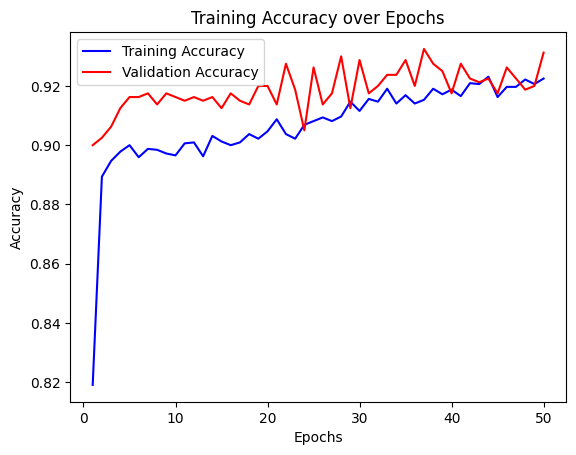

In [118]:
import matplotlib.pyplot as plt

train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy", color = 'Red')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [119]:
# Predict on the testing set
model2.load_weights(filepath)
score2 = model2.evaluate(cl_X_test_scaled, cl_y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.2035 - accuracy: 0.9120


In [120]:
score2[1]

0.9120000004768372

In [121]:
new = {'model_name': 'Neural Networks', 'classification_error': 1- score2[1]}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.10600
1,Logistic Regression after Best Subset Selection,0.10600
2,Quadratic Discriminant Analysis,0.10800
3,KNN Classification,0.09000
4,Decision Trees,0.08000
5,Random Forest,0.06625
6,SVM,0.09900
7,Neural Networks,0.08800


### Boosting

In [122]:
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_classifier.fit(cl_X_train, cl_y_train)

adaboost_predictions = adaboost_classifier.predict(cl_X_test)
adaboost_accuracy = accuracy_score(cl_y_test, adaboost_predictions)
boost_classification_error = 1 - adaboost_accuracy
print(f"Classification error:\n{boost_classification_error}\n")

Classification error:
0.09599999999999997



In [123]:
new = {'model_name': 'Boosting', 'classification_error': boost_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.10600
1,Logistic Regression after Best Subset Selection,0.10600
2,Quadratic Discriminant Analysis,0.10800
3,KNN Classification,0.09000
4,Decision Trees,0.08000
5,Random Forest,0.06625
6,SVM,0.09900
7,Neural Networks,0.08800
8,Boosting,0.09600


### Bagging

In [124]:
bag_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
bag_classifier.fit(cl_X_train, cl_y_train)

bag_predictions = bag_classifier.predict(cl_X_test)
bag_accuracy = accuracy_score(cl_y_test, bag_predictions)
bag_classification_error = 1 - bag_accuracy
print(f"Classification error:\n{bag_classification_error}\n")

Classification error:
0.06999999999999995



In [125]:
new = {'model_name': 'Bagging', 'classification_error': bag_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.10600
1,Logistic Regression after Best Subset Selection,0.10600
2,Quadratic Discriminant Analysis,0.10800
3,KNN Classification,0.09000
4,Decision Trees,0.08000
5,Random Forest,0.06625
6,SVM,0.09900
7,Neural Networks,0.08800
8,Boosting,0.09600
9,Bagging,0.07000


### Naive Bayes

In [126]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(cl_X_train, cl_y_train)

y_pred = naive_bayes_classifier.predict(cl_X_test)
accuracy = accuracy_score(cl_y_test, y_pred)
nb_classification_error = 1 - accuracy
print("Naive Bayes Classification error:", nb_classification_error)

Naive Bayes Classification error: 0.126


In [127]:
new = {'model_name': 'Naive Bayes', 'classification_error': nb_classification_error}
classification_model_performance.loc[len(classification_model_performance)] = new
classification_model_performance

,model_name,classification_error
0,Logistic Regression,0.10600
1,Logistic Regression after Best Subset Selection,0.10600
2,Quadratic Discriminant Analysis,0.10800
3,KNN Classification,0.09000
4,Decision Trees,0.08000
5,Random Forest,0.06625
6,SVM,0.09900
7,Neural Networks,0.08800
8,Boosting,0.09600
9,Bagging,0.07000


## Predict Value on Option Test Data

In [129]:
option_test = pd.read_csv('option_test_nolabel.csv')

In [130]:
option_test = option_test.drop(columns = ['Unnamed: 0'])

In [131]:
option_test.head(5)

,S,K,tau,r
0,1409.28,1325,0.126027,0.0115
1,1505.97,1100,0.315068,0.0110
2,1409.57,1450,0.197260,0.0116
3,1407.81,1250,0.101370,0.0116
4,1494.50,1300,0.194521,0.0110


In [137]:
train = option_train.drop(columns = ['Value', 'BS'])

In [138]:
train.head()

,S,K,tau,r
0,1394.46,1050,0.128767,0.0116
1,1432.25,1400,0.679452,0.0113
2,1478.90,1225,0.443836,0.0112
3,1369.89,1500,0.117808,0.0119
4,1366.42,1350,0.298630,0.0119


From the all modesl we tried, we can state that the best model to predict `Value` is the Neural Networks model, and the best model to predict `BS` is the Random Forest Model. Next we will predict the label for these two values in our option test data.

### Predict the `Value`

In [139]:
scaler = StandardScaler()
new_re_X_train_scaled = scaler.fit_transform(train)
re_option_test_scaled = scaler.transform(option_test)

In [140]:
from tensorflow.keras.models import load_model

best_model = load_model(filepath1)
re_predicted_labels = best_model.predict(re_option_test_scaled)

16/16 [==============================] - 0s 2ms/step


In [141]:
re_predicted_labels = [float(val) for val in re_predicted_labels]
re_predicted_labels = [f'{val:.2f}' for val in re_predicted_labels]
re_predicted_labels = [float(val) for val in re_predicted_labels]
re_predicted_labels[:10]

<ipython-input-141-963205dfc87f>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  re_predicted_labels = [float(val) for val in re_predicted_labels]


[109.52, 426.73, 38.49, 170.68, 217.38, 281.52, 39.11, 253.29, 288.4, 105.96]

### Predict the `BS`

In [145]:
model = RandomForestClassifier(n_estimators = 200, random_state=42,
                               max_features = 1)

model.fit(cl_X_train, cl_y_train)

cl_y_pred = model.predict(option_test)

In [146]:
cl_y_pred[:10]

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

### Create a csv File to store the results

In [147]:
result = {'Value': re_predicted_labels,
          'BS': cl_y_pred}

result = pd.DataFrame(result)
result.head(5)

,Value,BS
0,109.52,0
1,426.73,0
2,38.49,1
3,170.68,0
4,217.38,0


In [148]:
result.to_csv('group_18_prediction.csv', index = False)